____________________
# Music 255: Beautiful Soup and Billboard

A Notebook for scraping Billboard Chart Data.


**XML** stands for **eXtensible Markup Language**, and mainly serves to transport and store data. At its core, XML was designed to be **both machine- and human-readable**. 

XML is used widely on the web--**HTML** files are a kind of XML, in this case used for structured graphical representation of content. Read more about [**XML**](https://www.w3schools.com/xml/xml_syntax.asp).

**Beautiful Soup** is a Python library that allows us to interact with XML files--finding elements (the 'tags') and their attributes. Documentation: [here](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and [here](https://tedboy.github.io/bs4_doc/index.html).

**Beautiful Soup** can also be a good way to harvest information from structured webpages. In this tutorial we will explore the possibilities.

------
## Setup: Importing Python Libraries

```python
import os
from bs4 import BeautifulSoup as bs
import optparse
import sys
from pathlib import Path
import requests
import pandas as pd
import re
from collections import Counter
import glob

```

A list of all Beautiful Soup methods.  The most important for our work will be those that "find" elements and that 'get' the strings associated with various attributes and tags.


```python
dir(bs)
```


    ['ASCII_SPACES',
     'DEFAULT_BUILDER_FEATURES',
     'DEFAULT_INTERESTING_STRING_TYPES',
     'NO_PARSER_SPECIFIED_WARNING',
     'ROOT_TAG_NAME',
     '__bool__',
     '__call__',
     '__class__',
     '__contains__',
     '__copy__',
     '__delattr__',
     '__delitem__',
     '__dict__',
     '__dir__',
     '__doc__',
     '__eq__',
     '__format__',
     '__ge__',
     '__getattr__',
     '__getattribute__',
     '__getitem__',
     '__getstate__',
     '__gt__',
     '__hash__',
     '__init__',
     '__init_subclass__',
     '__iter__',
     '__le__',
     '__len__',
     '__lt__',
     '__module__',
     '__ne__',
     '__new__',
     '__reduce__',
     '__reduce_ex__',
     '__repr__',
     '__setattr__',
     '__setitem__',
     '__sizeof__',
     '__str__',
     '__subclasshook__',
     '__unicode__',
     '__weakref__',
     '_all_strings',
     '_decode_markup',
     '_feed',
     '_find_all',
     '_find_one',
     '_is_xml',
     '_lastRecursiveChild',
     '_last_descendant',
     '_linkage_fixer',
     '_markup_is_url',
     '_markup_resembles_filename',
     '_popToTag',
     '_should_pretty_print',
     'append',
     'childGenerator',
     'children',
     'clear',
     'decode',
     'decode_contents',
     'decompose',
     'decomposed',
     'default',
     'descendants',
     'encode',
     'encode_contents',
     'endData',
     'extend',
     'extract',
     'fetchNextSiblings',
     'fetchParents',
     'fetchPrevious',
     'fetchPreviousSiblings',
     'find',
     'findAll',
     'findAllNext',
     'findAllPrevious',
     'findChild',
     'findChildren',
     'findNext',
     'findNextSibling',
     'findNextSiblings',
     'findParent',
     'findParents',
     'findPrevious',
     'findPreviousSibling',
     'findPreviousSiblings',
     'find_all',
     'find_all_next',
     'find_all_previous',
     'find_next',
     'find_next_sibling',
     'find_next_siblings',
     'find_parent',
     'find_parents',
     'find_previous',
     'find_previous_sibling',
     'find_previous_siblings',
     'format_string',
     'formatter_for_name',
     'get',
     'getText',
     'get_attribute_list',
     'get_text',
     'handle_data',
     'handle_endtag',
     'handle_starttag',
     'has_attr',
     'has_key',
     'index',
     'insert',
     'insert_after',
     'insert_before',
     'isSelfClosing',
     'is_empty_element',
     'new_string',
     'new_tag',
     'next',
     'nextGenerator',
     'nextSibling',
     'nextSiblingGenerator',
     'next_elements',
     'next_siblings',
     'object_was_parsed',
     'parentGenerator',
     'parents',
     'parserClass',
     'popTag',
     'prettify',
     'previous',
     'previousGenerator',
     'previousSibling',
     'previousSiblingGenerator',
     'previous_elements',
     'previous_siblings',
     'pushTag',
     'recursiveChildGenerator',
     'renderContents',
     'replaceWith',
     'replaceWithChildren',
     'replace_with',
     'replace_with_children',
     'reset',
     'select',
     'select_one',
     'setup',
     'smooth',
     'string',
     'string_container',
     'strings',
     'stripped_strings',
     'text',
     'unwrap',
     'wrap']






In [8]:
import os
from bs4 import BeautifulSoup as bs
import optparse
import sys
from pathlib import Path
import requests
import pandas as pd
import re
from collections import Counter
import glob

In [9]:



# Replace this with the URL of the artist or chart you are trying to scrape.  In the case of individual artists, remember to include the full URL shown here (including the `chart-history`)
url = "https://www.billboard.com/artist/miles-davis/chart-history/tlp/"  

# example of top 100:
# url = 'https://www.billboard.com/charts/hot-100/'
response = requests.get(url)
soup = bs(response.text, 'html.parser')




## Scraping Tabular Data

Scraping tabular data from pages of the sort created by Billboard requires some careful attention to the structure of the XML.  Billoard has a lot of distracting ads, so a first step is to hide as many of those as possible.

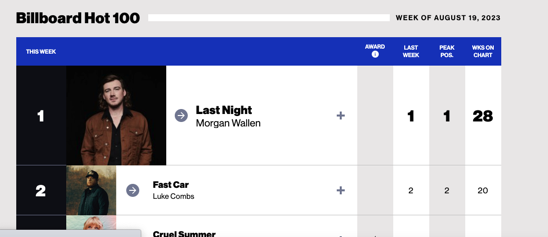

Now with the clean view, use your browser menu to find the "inspect elements" option in your View or Developer tools.  This will show you the blocks of HTML that correspond to what you are seeing in the table.

The individual rows will be one HTML 'class' or identifier.  Take note of the name.  In the case of Billoard Artist View, it's called `o-chart-results-list-row`.

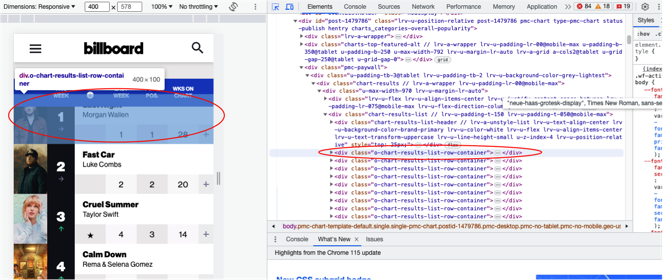

Hover over each of the columns you want to capture (such as "This Week", or "Last Week", or the "Artist Name" or "Track Title"). As you do, take note of the class. 

 - The artist and title are 'h3' tags
 - The ranking and date information columns are of the class `o-chart-results-list__item`.  


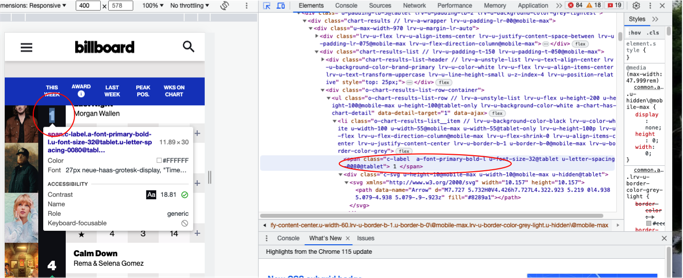

We now translate each of these into Beautiful Soup requests. 

Each song will begin with a tag of that has the class attribute 'o-chart-results-list-row'.  So a list of all songs would be:

`all_songs = soup.find_all(attrs={'class' : 'o-chart-results-list-row'})`

We iterate over all the songs in the chart, saving each row/cell as a variable:

```python
for this_song in all_songs:
    title = this_song.h3.get_text(strip=True)
    author = this_song.h3.find_next('span').get_text(strip=True)
    this_song_details = this_song.find_all(attrs={'class': 'o-chart-results-list__item'})
    release_date = this_song_details[0].find_next(attrs={'class': 'o-chart-results-list__item'}).get_text(strip=True)
    peak_weeks = this_song_details[1].find_next(attrs={'class': 'o-chart-results-list__item'}).get_text(strip=True)
    peak_date = this_song_details[2].find_next(attrs={'class': 'o-chart-results-list__item'}).get_text(strip=True)
    total_weeks = this_song_details[3].find_next(attrs={'class': 'o-chart-results-list__item'}).get_text(strip=True)
```

And save the results as dictionary, which is in turn saved to a list of dictionaries, each representing the required data for one row:

```python
chart_data.append({
            'title': title,
            'author': author,
            'release_date': release_date,
            'peak_weeks': peak_weeks,
            'peak_date': peak_date,
            'total_weeks': total_weeks,
        })
```
Finally the list of dictionaries becomes a dataframe:

```python
df = pd.DataFrame(chart_data)
df
```



## Artist vs Top 100 Lists

The tables for Artist and Top 100 charts are slightly different in their arrangement.  The code below checks the URL to which you have selected, and creates the tables accordingly

In [10]:


if 'artist' in url:
    chart_data = []
    all_songs = soup.find_all(attrs={'class' : 'o-chart-results-list-row'})
    # iterate over all the songs in the chart
    for this_song in all_songs:
        title = this_song.h3.get_text(strip=True)
        author = this_song.h3.find_next('span').get_text(strip=True)
        this_song_details = this_song.find_all(attrs={'class': 'o-chart-results-list__item'})
        release_date = this_song_details[0].find_next(attrs={'class': 'o-chart-results-list__item'}).get_text(strip=True)
        peak_weeks = this_song_details[1].find_next(attrs={'class': 'o-chart-results-list__item'}).get_text(strip=True)
        peak_date = this_song_details[2].find_next(attrs={'class': 'o-chart-results-list__item'}).get_text(strip=True)
        total_weeks = this_song_details[3].find_next(attrs={'class': 'o-chart-results-list__item'}).get_text(strip=True)
        chart_data.append({
            'title': title,
            'author': author,
            'release_date': release_date,
            'peak_weeks': peak_weeks,
            'peak_date': peak_date,
            'total_weeks': total_weeks,
        })

    df = pd.DataFrame(chart_data)
    df

elif 'charts' in url:
    data = []
    for e in soup.find_all(attrs={'class':'o-chart-results-list-row-container'}):
        # spans = e.find_all('span')
        this_week = e.span.get_text(strip=True)
        last_week = e.h3.find_next('span').find_next('span').get_text(strip=True)
        peak_position = e.h3.find_next('span').find_next('span').find_next('span').get_text(strip=True)
        weeks_on_chart = e.h3.find_next('span').find_next('span').find_next('span').find_next('span').get_text(strip=True)
        data.append({
            'title':e.h3.get_text(strip=True),
            'author':e.h3.find_next('span').get_text(strip=True),
            'this_week' : this_week,
            'last_week': last_week,
            'peak_position': peak_position,
            'weeks_on_chart': weeks_on_chart
        })
    df = pd.DataFrame(data)
    df
    
df

,title,author,release_date,peak_weeks,peak_date,total_weeks
0,Bitches Brew,Miles Davis,05.16.70,3512 Wks,07.04.70,29
1,The Man With The Horn,Miles Davis,07.25.81,5312 Wks,09.12.81,18
2,Seven Steps To Heaven,Miles Davis,09.14.63,6212 Wks,10.05.63,15
3,Live--Evil,Miles Davis,12.25.71,12512 Wks,02.12.72,14
4,You're Under Arrest,Miles Davis,06.01.85,11112 Wks,06.29.85,12
5,Miles Davis At Fillmore,Miles Davis,12.12.70,12312 Wks,01.02.71,12
6,On The Corner,Miles Davis,11.18.72,15612 Wks,12.09.72,11
7,Decoy,Miles Davis,06.30.84,16912 Wks,07.28.84,11
8,Tutu,Miles Davis,10.25.86,14112 Wks,11.15.86,10
9,Miles Davis In Europe,Miles Davis,09.26.64,11612 Wks,11.21.64,10


In [ ]:
df.to_csv("Miles_Davis_Billboard.csv")